my_callbacks = [
        # abandona o processamento se a acurácia não melhorar em até {patitence} épocas
        #tf.keras.callbacks.EarlyStopping(monitor='val_acc',patience=6), 
        # grava os modelos intermediários
        tf.keras.callbacks.ModelCheckpoint(filepath='model/model.{epoch:02d}.h5'), # salva o modelo para poder retomar o treinamento
        # grava informações para visualização
        # tf.keras.callbacks.TensorBoard(log_dir='./logs'), 
        #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.0001)
]

history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=300,
    validation_split=0.2,
    callbacks=my_callbacks,
)# Instituto de Educação Superior de Brası́lia – IESB
## Pós-Graduação em Inteligência Artificial
### Disciplina de Computação Cognitiva 3 / Turma 2021-1
#### Trabalho Final - Análise de Sentimento

                          EQUIPE:
                          - LUCAS DE SOUSA BRITO, MAT:2186330019, TURMA: 2021-1
                          - PABLO NOGUEIRA OLIVEIRA, MAT:2186330027, TURMA: 2021-1
                          - MATHEUS BARBOSA OLIVEIRA, MAT:2186330037, TURMA: 2021-1

# Análise de sentimento da base do twitter Sentiment140

### Dados de Origem

* http://help.sentiment140.com/for-students

| sentiment  | id | date | query_string | user | text
| ---        | -- | -    | -            | -    | ---
| 0=negativo | -  | -    | -            | -    | the original twitter message
| 2=neutro   | -  | -    | -            | -    | 
| 4=positivo | -  | -    | -            | -    |


```



In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np

tf.random.set_seed(129783)
np.random.seed(3213)

# Importação

Dados de origem: 
* http://help.sentiment140.com/for-students
* colunas:
   * sentiment (0=negativo, 2=neutro, 4=positivo)
   * id
   * date
   * query_string
   * user
   * text

Para este exercício:
* apenas as colunas sentiment e text serão mantidas
* sentimentos neutros serão descartados
* sentimentos serão padronizados como 0=negativo e 1=positivo


In [3]:
def bloco():
    
    global df_original
    
    df_cols = ['sentiment','id','date','query_string','user','text']

    df_original = pd.read_csv(
        "training.1600000.processed.noemoticon.csv",
        header=None, 
        names=df_cols,
        encoding = "ISO-8859-1",
        #nrows=1000
    )

    df_original.drop(
        ['id','date','query_string','user'],
        axis=1,
        inplace=True
    )
    df_original = df_original[ df_original['sentiment'] != 2 ] 
    df_original['sentiment'] = df_original['sentiment'].apply( lambda x: 1 if x==0 else 0 )
    return df_original

bloco()

,sentiment,text
0,1,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1,is upset that he can't update his Facebook by ...
2,1,@Kenichan I dived many times for the ball. Man...
3,1,my whole body feels itchy and like its on fire
4,1,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,0,Just woke up. Having no school is the best fee...
1599996,0,TheWDB.com - Very cool to hear old Walt interv...
1599997,0,Are you ready for your MoJo Makeover? Ask me f...
1599998,0,Happy 38th Birthday to my boo of alll time!!! ...


# Padronização (1)

* Parte 1
  * remove todas as tags
  * remove urls
  * remove identificadores de usuários 
  * remove caracteres unicode inválidos
  * remove carcteres não textuais
  * transforma tudo para minúsculas
* Parte 2
  * tokeniza usando o keras
* Parte 3
  * separa base de treinamento e de teste

In [4]:
#data_limit = 200000
max_words = 100000
max_len = 50

vocabulario = {}
    
def vocabulario_get(w):
    if w in vocabulario:
        return vocabulario[w]
    else:
        vocabulario[w] = len(vocabulario)
        return vocabulario[w]


#import nltk.wordnet

# https://www.nltk.org/howto/tokenize.html#regression-tests-tweettokenizer
from nltk.tokenize import TweetTokenizer    
# stemmer
from nltk.stem import PorterStemmer

nltk_tokenizer = TweetTokenizer(strip_handles=True,reduce_len=True)
nltk_stemmer = PorterStemmer()
#keras_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words,lower=True, split=" ")

vocabulario = {}

def tokenize(x):
    x = nltk_tokenizer.tokenize( x )
    x = [ nltk_stemmer.stem( a ) for a in x ]
    x = [ '' if a.startswith('http') else a for a in x ]    
    x = [ vocabulario_get(a) for a in x ]         
    x = tf.keras.preprocessing.sequence.pad_sequences( [x], maxlen=max_len )[0]
    return x

df_exemplo = df_original.sample(5)
df_exemplo['tokenizado'] = df_exemplo['text'].apply( tokenize )

from pandas import option_context
with option_context('display.max_colwidth', 400):
    display(df_exemplo)

,sentiment,text,tokenizado
562641,1,Eyes wide shzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz... i think 3 hours sleep a night is finally catching up with me,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]"
1596542,0,@SarY_ChaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
557121,1,"Well, the question as to whether I should get up at 5 has been sufficiently answered. #NASA #STS-127 #Endeavor","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 18, 19, 20, 21, 22, 23, 4, 24, 25, 14, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]"
1176192,0,Picnic in the sun,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 37, 19, 38]"
1400171,0,Good morning! i'm outside and its a beautiful day! watched picture this last night it just gets more and more amazing!,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 40, 41, 42, 43, 44, 45, 9, 46, 47, 41, 48, 49, 50, 51, 10, 45, 52, 25, 53, 44, 53, 54, 41]"


In [5]:
def bloco():
    
    global df_original
    global df_train
    global df_test   
   
    # 1 = train | 0 = test
    df_original['rand'] = pd.Series([0,1]).sample(len(df_original), replace=True).array
    
    df_train_sz = 40000
    df_train = df_original[ df_original[ 'rand' ] == 1 ]
    df_train_positive = df_train[ df_train['sentiment'] == 0 ].sample(n=int(df_train_sz/2), replace=True)
    df_train_negative = df_train[ df_train['sentiment'] == 1 ].sample(n=int(df_train_sz/2), replace=True)
    df_train = pd.concat( [ df_train_negative, df_train_positive ] )    
    df_train = df_train.sample(frac=1.0)
    
    df_test_sz = 40000
    df_test = df_original[ df_original[ 'rand' ] == 0 ].sample(int(df_test_sz), replace=True)
    df_test = df_test.sample(frac=1.0)
    
bloco()
df_test

,sentiment,text,rand
157215,1,It's been another really crazy week...heading ...,0
1046654,0,is making a graffiti for tobit. http://plurk....,0
824395,0,Ya notaron que sale &quot;el profesor patiï¿½o...,0
1249669,0,Just got done watching Eagle Eye in Spanish. H...,0
1089198,0,"@Chelsa_love i posted them on the site, hope t...",0
...,...,...,...
1417958,0,"@kristinhucko I think its her real home, the o...",0
1377089,0,@MyNameisRazzle no I think you're funny you ju...,0
1516062,0,"here comes the rain again, nice",0
852614,0,breaking in entering?... no just borrowing a p...,0


# Modelo

In [6]:
model = tf.keras.Sequential()         
model.add(tf.keras.layers.Embedding(max_words, 16))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(128, activation='relu', use_bias=False))
model.add(tf.keras.layers.Dropout(0.50))
model.add(tf.keras.layers.Dense(64, activation='relu', use_bias=False))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

import tensorflow_addons as tfa

model.compile(
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01,momentum=0.1),
    loss='binary_crossentropy', 
    metrics=[
        'acc',        
        tf.keras.metrics.Precision(name='prec'),
        tf.keras.metrics.Recall(name='recall'),
        tfa.metrics.F1Score(num_classes=1, threshold=0.5, name='f1')
    ]
)
model.summary()

2022-05-31 20:08:26.660310: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-31 20:08:26.660379: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lucas-n001
2022-05-31 20:08:26.660392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lucas-n001
2022-05-31 20:08:26.661041: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-05-31 20:08:26.661103: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.5
2022-05-31 20:08:26.661115: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.73.5
2022-05-31 20:08:26.663548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          1600000   
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8192      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8192      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [7]:
X_train = np.array( [ tokenize( a ) for a in df_train['text'] ] )
y_train = df_train['sentiment'].values
print( f'X.shape={X_train.shape} y.shape={y_train.shape}' )

X.shape=(40000, 50) y.shape=(40000,)


In [8]:
my_callbacks = [
        # abandona o processamento se a acurácia não melhorar em até {patitence} épocas
        tf.keras.callbacks.EarlyStopping(monitor='val_acc',patience=6), 
        # grava os modelos intermediários
        tf.keras.callbacks.ModelCheckpoint(filepath='model/model.{epoch:02d}.h5'), # salva o modelo para poder retomar o treinamento
        # grava informações para visualização
        # tf.keras.callbacks.TensorBoard(log_dir='./logs'), 
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.00001)
    ]

history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=128,
    validation_split=0.10,
    callbacks=my_callbacks,
)
print('OK')

Epoch 1/30
282/282 [==============================] - 27s 80ms/step - loss: 0.5771 - acc: 0.7071 - prec: 0.6997 - recall: 0.7266 - f1: 0.7129 - val_loss: 0.5329 - val_acc: 0.7565 - val_prec: 0.7906 - val_recall: 0.6925 - val_f1: 0.7383 - lr: 0.0100
Epoch 2/30
282/282 [==============================] - 15s 54ms/step - loss: 0.4652 - acc: 0.7937 - prec: 0.7808 - recall: 0.8174 - f1: 0.7987 - val_loss: 0.4777 - val_acc: 0.7610 - val_prec: 0.7180 - val_recall: 0.8533 - val_f1: 0.7798 - lr: 0.0100
Epoch 3/30
282/282 [==============================] - 15s 54ms/step - loss: 0.4029 - acc: 0.8305 - prec: 0.8172 - recall: 0.8519 - f1: 0.8342 - val_loss: 0.5238 - val_acc: 0.7703 - val_prec: 0.8098 - val_recall: 0.7016 - val_f1: 0.7518 - lr: 0.0100
Epoch 4/30
282/282 [==============================] - 16s 58ms/step - loss: 0.3437 - acc: 0.8621 - prec: 0.8526 - recall: 0.8758 - f1: 0.8641 - val_loss: 0.4948 - val_acc: 0.7703 - val_prec: 0.7789 - val_recall: 0.7495 - val_f1: 0.7639 - lr: 0.0100
Epoc

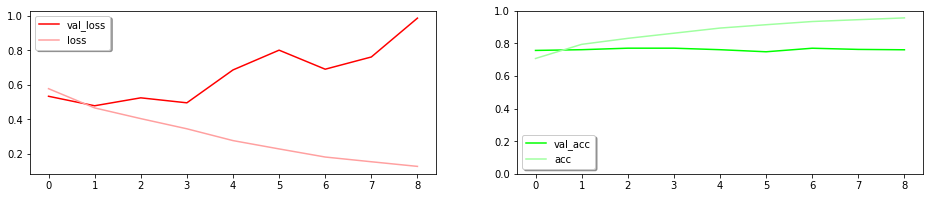

In [9]:
def bloco():
    
    import matplotlib.pyplot as plt
    
    def graph(history):
        fig, ax = plt.subplots(1,2,figsize=(16,3))
        ax[0].plot(history.history['val_loss'], color='#FF0000', label="val_loss")
        ax[0].plot(history.history['loss'], color='#FFA0A0', label="loss")
        legend = ax[0].legend(loc='best', shadow=True)

        ax[1].plot(history.history['val_acc'], color='#00FF00', label="val_acc")
        ax[1].plot(history.history['acc'], color='#A0FFA0', label="acc")
        ax[1].set_ylim([0.0,1.0])
        legend = ax[1].legend(loc='best', shadow=True)        
        
    graph(history)
    
bloco()


In [ ]:
def bloco():
    
    print( 'Seleciona o modelo com maior acurácia durante a validação (usualmente antes do overfit)' )
    
    best_acc = max(history.history['val_acc'])
    best_epoch = history.history['val_acc'].index(best_acc) + 1
    
    print( f'melhor epoca: {best_epoch} val_acc={best_acc:1.2f}' )    
        
    model.load_weights( f'model/model.{best_epoch:02d}.h5' )

bloco()

In [10]:
X_test = np.array( [ tokenize( a ) for a in df_test['text'] ] )
y_test = df_test['sentiment'].values
y_pred = [ 1 if y_pred > 0.5 else 0 for y_pred in model.predict(X_test).reshape(len(X_test)) ]

df_test['predicted'] = y_pred
df_test[ ['text','sentiment','predicted'] ]

1250/1250 [==============================] - 13s 10ms/step


,text,sentiment,predicted
157215,It's been another really crazy week...heading ...,1,0
1046654,is making a graffiti for tobit. http://plurk....,0,0
824395,Ya notaron que sale &quot;el profesor patiï¿½o...,0,1
1249669,Just got done watching Eagle Eye in Spanish. H...,0,1
1089198,"@Chelsa_love i posted them on the site, hope t...",0,0
...,...,...,...
1417958,"@kristinhucko I think its her real home, the o...",0,1
1377089,@MyNameisRazzle no I think you're funny you ju...,0,0
1516062,"here comes the rain again, nice",0,0
852614,breaking in entering?... no just borrowing a p...,0,1


In [11]:
def block():
    
    global confusion_mtx
    global confusion_mtx_pc
    
    confusion_mtx = tf.math.confusion_matrix( y_test, y_pred )

    confusion_mtx = pd.DataFrame( confusion_mtx )
    confusion_mtx.loc['Total'] = confusion_mtx.sum(numeric_only=True) 
    confusion_mtx['total'] = confusion_mtx[0] + confusion_mtx[1]
    
    confusion_mtx_pc = confusion_mtx / len(y_test)
    
    fp = confusion_mtx.iloc[0,1] 
    fn = confusion_mtx.iloc[1,0]
    tn = confusion_mtx.iloc[0,0]
    tp = confusion_mtx.iloc[1,1] 
    
    total = (tp+tn+fp+fn)
    
    acc       = (tp+tn)/(tp+tn+fp+fn)
    recall    = tp/(tp+fn)
    f1        = (2*acc*recall)/(acc+recall)
    
    fdr  = fp/(fp+tp)
    fnr  = fn/(fn+tp)
    
    tpr = tp/(fn+tp)
    ppv  = tp/(fp+tp)
    
    
    from IPython.display import display, HTML
    display(HTML(f"""
    
        <style>
           .luc_confusion_mtx td {{ background: white!IMPORTANT; border: 0pt !IMPORTANT; text-align: center!IMPORTANT }}           
           td.luc_confusion_mtx_dp {{ width: 90pt; height: 90pt; background: #c0ffc0!IMPORTANT; border: 1pt solid black!IMPORTANT }} 
           td.luc_confusion_mtx_dn {{ width: 90pt; height: 90pt; background: #ffc0c0!IMPORTANT; border: 1pt solid black!IMPORTANT }}            
        </style>
        5
               
        <table class='luc_confusion_mtx'>
        <tr>
            <td></td>
            <td></td>
            <td colspan=2>Previsão</td>
            <td></td>
            <td rowspan=5 style='text-align: left!IMPORTANT'>
                    Acurácia<br><big><big>(TP+TN)/(total)</big></big> = {tp+tn}/{total} = <big>{(tp+tn)*100.0/total:2.1f}%</big><br>
                    <br><br>5
                    Considerando que as duas classes (0=sentimento negativo;1=sentimento positivo) tem igual 
                    valor para esta análise, é importante maximizar a diagonal verde / minimizar a diagonal vermelha,
                    portanto os indicadores de Acurácia OU F1 são os mais indicados.<br>
                    <br>
                    Os indicadores de precisão e sensibilidade(recall) podem ser usados em conjunto, mas não são
                    muito intuitivos para este conjunto de dados pois mensuram da perspectiva do "sentimento positivo".
                    Em outras palavras, a sensibilidade indica quantos "sentimentos positivos" corretos foram encontrados
                    e a "precisão" indica do total apontado pelo modelo como "sentimento positivo", quantos eram. 
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>Negativo</td>
            <td>Positivo</td>
            <td></td>            
        </tr>
        <tr>
            <td rowspan=2>Real</td>
            <td>Negativo</td>
            <td class="luc_confusion_mtx_dp"><big><big>TN</big></big><br>{tn}<br>{tn*100.0/total:2.1f}%</td>
            <td class="luc_confusion_mtx_dn"><big><big>FP</big></big><br>{fp}<br>{fp*100.0/total:2.1f}%</td>
            <td>{tn+fp}</td>
        </tr>        
        <tr>
            <td>Positivo</td>
            <td class="luc_confusion_mtx_dn"><big><big>FN</big></big><br>{fn}<br>{fn*100.0/total:2.1f}%</td>
            <td class="luc_confusion_mtx_dp"><big><big>TP</big></big><br>{tp}<br>{tp*100.0/total:2.1f}%</td>
            <td>{fn+fp}</td>
        </tr>  
        <tr>
            <td></td>
            <td></td>
            <td>{tn+fn}</td>
            <td>{fp+tp}</td>
            <td>{total}</td>
        </tr>  
        </table>    
        
        
       
    """))        
    
    print( f'             Acurácia={acc*100.0:05.2f}% dos apontamentos positivos e negativos estão corretos' )
    print( f' Recall/Sensibilidade={tpr*100.0:05.2f}% dos sentimentos positivos da base foram apontados' )   
    print( f'             Precisão={ppv*100.0:05.2f}% dos sentimentos positivos apontados estão corretos' )    
    print( f'             F1 Score={f1*100.0:05.2f}% média harmônica da acurácia e recall' )        
      

    
block()





             Acurácia=74.62% dos apontamentos positivos e negativos estão corretos
 Recall/Sensibilidade=77.06% dos sentimentos positivos da base foram apontados
             Precisão=73.37% dos sentimentos positivos apontados estão corretos
             F1 Score=75.82% média harmônica da acurácia e recall
